In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Latest Date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

# Calculate the date 1 year ago from the last data point in the database
year_ago_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(year_ago_date)

# Perform a query to retrieve the data and precipitation scores
precipitation_last_year = (session.query(Measurement.date, Measurement.prcp).
    filter(Measurement.date >= year_ago_date).
    order_by(Measurement.date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_last_year_df = pd.DataFrame(precipitation_last_year, columns=["Date","Precipitation"])
print(precipitation_last_year_df)

# Sort the dataframe by date
sorted_precipitation_last_year_df = precipitation_last_year_df.sort_values(by=['Date'], ascending=False)
print(sorted_precipitation_last_year_df)


('2017-08-23',)
2016-08-23
            Date  Precipitation
0     2016-08-23           0.00
1     2016-08-23           0.15
2     2016-08-23           0.05
3     2016-08-23            NaN
4     2016-08-23           0.02
...          ...            ...
2225  2017-08-22           0.50
2226  2017-08-23           0.00
2227  2017-08-23           0.00
2228  2017-08-23           0.08
2229  2017-08-23           0.45

[2230 rows x 2 columns]
            Date  Precipitation
2229  2017-08-23           0.45
2228  2017-08-23           0.08
2227  2017-08-23           0.00
2226  2017-08-23           0.00
2225  2017-08-22           0.50
...          ...            ...
3     2016-08-23            NaN
1     2016-08-23           0.15
5     2016-08-23           1.79
6     2016-08-23           0.70
0     2016-08-23           0.00

[2230 rows x 2 columns]


C:\Users\nvkar\anaconda3\envs\PythonData\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


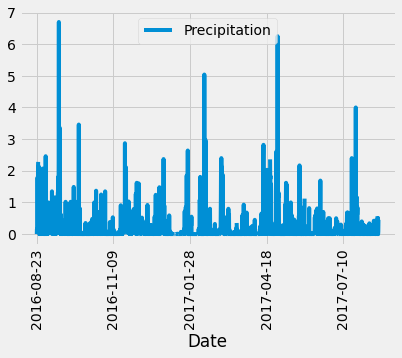

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data

bar_plot = precipitation_last_year_df.plot(x='Date', y='Precipitation',rot=90)

plt.legend(loc='upper center')
plt.savefig("Images/precipitation.png")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_last_year_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stations_number = session.query(Measurement.station).distinct().count()
stations_number

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = (session.query(Measurement.station, func.count(Measurement.station)).
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc())).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

min_max_avg_temps = (session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).
    filter(Measurement.station == 'USC00519281')).all()
min_max_avg_temps

[(54.0, 85.0, 71.66378066378067)]

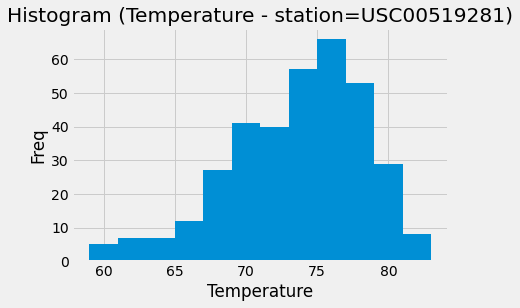

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_last_year = (session.query(Measurement.date, Measurement.tobs).
    filter(Measurement.station == 'USC00519281').
    filter(Measurement.date >= year_ago_date).
    order_by(Measurement.date)).all()
station_last_year

#Save as a dataframe
temp_station_df = pd.DataFrame(station_last_year, columns = ['Date', 'Temp'])
temp_station_df

#Hist
temp_station_df['Temp'].hist(bins=12)

plt.title("Histogram (Temperature - station=USC00519281)")
plt.xlabel("Temperature")
plt.ylabel("Freq")
plt.savefig("Images/Histogram_Temp.png", bbox_inches='tight')
plt.show()

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_temp = calc_temps('2017-05-01', '2017-06-05')
my_temp

[(65.0, 75.57073170731708, 87.0)]

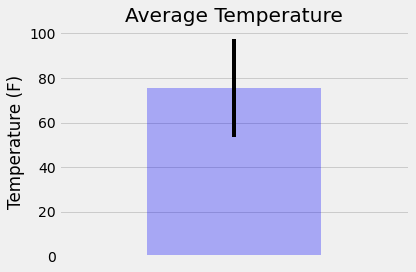

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_temp_df = pd.DataFrame(my_temp, columns=["T_min", "T_avg", "T_max"])

my_temp_df.plot.bar(y="T_avg", yerr=(my_temp_df["T_max"] - my_temp_df["T_min"]), 
                    title="Average Temperature", color="blue", 
                    alpha=0.3, legend=None)
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("Images/average_temperature.png")
plt.show()


In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def total_rainfall(start_date, end_date):
    return session.query(Measurement.station,
                         Stations.name,
                         Measurement.prcp,
                         Stations.latitude,
                         Stations.longitude,
                         Stations.elevation).\
                            group_by(Measurement.station).\
                            join(Stations, Measurement.station == Stations.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by((Measurement.prcp).desc()).all()

total_rainfall('2017-05-01', '2017-06-05')

#total_rainfall_df = pd.DataFrame(total_rainfall, columns=["Station number", "Name", "Ranefall", "Lat","Long","Elevation"])

[('USC00519397', 'WAIKIKI 717.2, HI US', 0.26, 21.2716, -157.8168, 3.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.25,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.13,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.07,
  21.33556,
  -157.71139,
  19.5),
 ('USC00513117', 'KANEOHE 838.1, HI US', 0.07, 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.03,
  21.5213,
  -157.8374,
  7.0),
 ('USC00517948', 'PEARL CITY, HI US', None, 21.3934, -157.9751, 11.9)]

In [74]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
